# :: Tunable First-Order Inexact Oracles (TFOIO) Practical Cases ::
`Performance analysis of deterministic gradient based methods using (global) tunable first-order inexact oracles.`

**Author** : *Guillaume Van Dessel*, Ph.D. candidate @EPL

**Version** : 3.1 | working version for $d_p$=1

**Comment** : For now on, let's stick to fully deterministic methods (however those might be inexact as well but there must be 
no source of randomness at each update step apart from oracle's content)

**Requirements** : Please *pip* install the following packages in order to fully exploit toolbox's possibilities 

 [appmode]  (https://github.com/oschuett/appmode)
 
 [import-ipynb] (https://pypi.org/project/import-ipynb/)
                
 [ipywidgets] (https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html)

In [1]:
## packages' import
%matplotlib notebook
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
from scipy.stats import wald,norm,f,expon,chi2,uniform
import scipy.linalg as scla
from IPython.display import display,clear_output
from ipywidgets import *
import decimal
np.warnings.filterwarnings('ignore')

## from the auxiliary notebook
import import_ipynb
from TFOIO_functions import solve_KKT_i,solve_KKT_ii,N_lower,compute_serial_coeffs,partitioner

importing Jupyter notebook from TFOIO_functions.ipynb


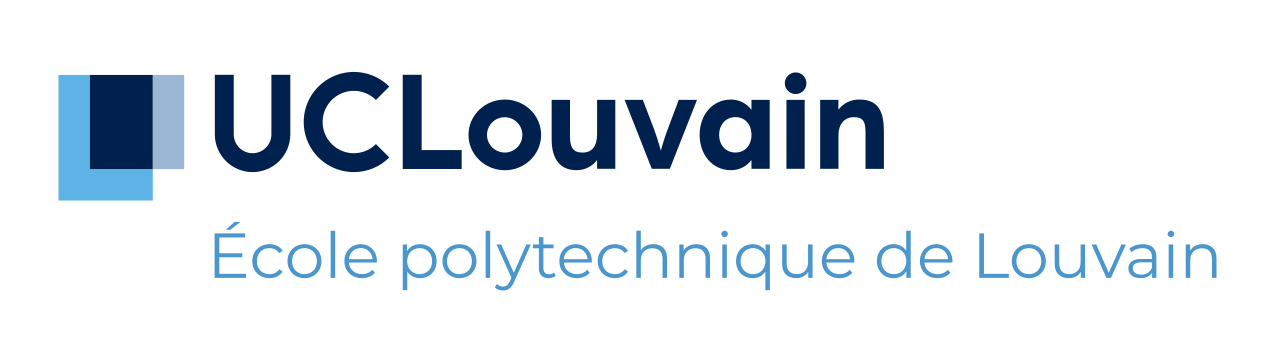

In [2]:
from IPython.display import Image
Image(filename='epl.png')

____________________________________________________________________________________

In [3]:
# aux. funs. for oracles

def gaussian_perturbation(x,eta):
    direc = np.random.normal(0,1,len(x))
    return direc/scla.norm(direc)*eta

def closest_lattice_point(x,eta):
    if eta==0:
        return x
    else:
        return np.array([(np.floor(x_j/eta) + (x_j-np.floor(x_j/eta)*eta-eta/2>=0))*eta for x_j in x])

In [4]:
# @instantiation of the possibility lists 

# objective function list
obj_list = ['generic','other'] # add practical things

# search space dimension 
d = 10

#####################################################################################################################################

# @creation of inherent widgets

widget_obj = widgets.Dropdown(
    options=obj_list,
    value=obj_list[0],
    description='obj. fun.: ',
)

widget_d = widgets.IntSlider(
    value=d,
    min=1,
    max=100,
    step=1,
    description='dimension:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

widget_cons = widgets.Checkbox(
    value=False,
    description='constrained?',
    disabled=False
)

widget_distance = BoundedFloatText(
    value=0,
    min=0,
    max=1000.0,
    step=0.05,
    description='center norm:',
    disabled=False)

In [5]:
def change_R(R):
    Problem.R = R
    if Problem.type_dom is None:
        direc_base = norm.rvs(loc=0, scale=1, size=Problem.d)
        Problem.x_0 = Problem.x_star + Problem.R*direc_base/scla.norm(direc_base)
    elif Problem.type_dom == 'ball':
        direc_base = Problem.center - Problem.x_star 
        Problem.x_0 = Problem.x_star + Problem.R*direc_base/scla.norm(direc_base)
    elif Problem.type_dom == 'box':
        workload = Problem.R**2
        arr = np.arange(Problem.d)
        np.random.shuffle(arr)
        buf = Problem.x_star.copy()
        for j in arr:
            if Problem.x_star[j] > Problem.center[j]:
                dec = np.min([workload,(Problem.x_star[j]-(Problem.center[j]-Problem.scale))**2])
                buf[j] = Problem.x_star[j]-np.sqrt(dec)
                workload -= dec
            else:
                dec = np.min([workload,((Problem.center[j]+Problem.scale)-Problem.x_star[j])**2])
                buf[j] = Problem.x_star[j] + np.sqrt(dec)
                workload -= dec
        Problem.x_0 = buf

In [6]:
direc_base = norm.rvs(loc=0, scale=1, size=10)

# @default Problem class
class Problem:
    
    f = lambda x: (1/2)*np.sum(x**2)
    dif_f = lambda x: x
    mu = 0.1
    L = 10
    d = 10
    m = 0
    constr = False
    x_star = np.zeros(d)
    scale = 5
    center = None
    type_dom = None
    Q = np.inf
    update = lambda h,u: u
    la = 1e-15
    R = 10
    lb = 1
    bool_lb = True
    epsilon = 1e-5
    beta = 1
    alpha = 0.1
    beta_prime = 9.9/8
    gamma = 9.9
    met = 'FGD'
    cost_model = 'inv_prop'
    K = 10
    q = 20.1
    j = 2
    r = 1
    beta2 = 1
    N = 144
    x_0 = R*direc_base/scla.norm(direc_base)
    scale2 = 'log'
    situation = 'approx_grad_sc'
    sc_param = 0.05
    L_param = 20
    last_situation = 'approx_grad_sc'
    used_oracle = lambda x,eta: (f(x),dif_f(x))
    eta_sched = np.zeros(N)
    eta_sched_const = np.zeros(N)
    cost_iteration = lambda eta: 10 + beta_2/(eta)
    eta_req = lambda epsilon: (epsilon*j/(2*q))**(1/j)
    
    
def short_not(float_number):
    return '%.3e' % decimal.Decimal(str(float_number))
    
def present_Problem():
    
    print(' ')
    print('|| problem summary ||')
    print('---------------------')
    print(' ')
    if Problem.constr:
        if Problem.type_dom is 'box':
            print('=> constrained in a box defined by :')
            if Problem.d <= 5:
                buf='['+short_not(Problem.center[0]-Problem.scale)+' , '+short_not(Problem.center[0]+Problem.scale)+']'
                for elem in np.linspace(1,Problem.d-1,Problem.d-1):
                    buf+=' X ['+short_not(Problem.center[int(elem)]-Problem.scale)+' , '\
                    +short_not(Problem.center[int(elem)]+Problem.scale)+']'
            else:
                buf = 'U from i = 1 to '+str(Problem.d)+' [c_i - '+str(Problem.scale)+' , c_i + '+str(Problem.scale)+']'
            print(buf)
        else:
            print('=> constrainted in a ball defined by : ')
            print(' B := {x in R^'+str(int(Problem.d))+' | ||x-c|| <= '+str(Problem.scale)+'}')
    else: 
        print('=> unconstrained ')
    print(' ')
    print('dimension : '+str(int(Problem.d)))
    print('estimated strong convexity parameter : '+str(Problem.mu))
    print('estimated smoothness parameter : '+str(Problem.L))
    print('activated constraints at optimum : '+str(int(Problem.m)))
    if Problem.d <= 20:
        print('optimum : '+str(Problem.x_star))
    print(' ')
    
def reset_Problem():
    
    Problem.f = lambda x: (1/2)*np.sum((x-Problem.x_star)**2)
    Problem.dif_f = lambda x: (x-Problem.x_star)
    Problem.mu = 1
    Problem.L = 1

In [7]:
### models 
def free(dist):
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    Problem.x_star = dist*direc/scla.norm(direc)
    Problem.Q = np.inf
    
    Problem.center = Problem.x_star
    
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    Problem.max_R = 10000000
    widget_R = BoundedFloatText(
        value=10,
        min=0,
        max=Problem.max_R,
        step=1,
        description='R:',
        disabled=False)
    
    interact(change_R,R = widget_R)
    
def ball_proj(u,center,scale):
    return center + (u-center)/np.max([scale,scla.norm(u-center)])
    
def ball_constraint(center,m,scale):
    
    Problem.m = m
    Problem.scale = scale
    Problem.Q = 2*Problem.scale
    Problem.update = lambda h,u: ball_proj(u,Problem.center,Problem.scale)
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    
    if m==1:
        Problem.x_star = center+scale*direc/scla.norm(direc)
    else:
        Problem.x_star = center+(scale*np.random.uniform(0,1)**(1/Problem.d))*direc/scla.norm(direc)
        
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    Problem.max_R = Problem.scale + scla.norm(Problem.x_star-Problem.center)
    widget_R = BoundedFloatText(
        value=10,
        min=0,
        max=Problem.max_R,
        step=1,
        description='R:',
        disabled=False)
    
    interact(change_R,R = widget_R)
    
def box_proj(u,center,scale):
    buf = []
    bounds = [center-scale,center+scale]
    for j in np.arange(len(u)):
        if u[j]<bounds[0][j]:
            buf.append(bounds[0][j])
        elif u[j]>bounds[1][j]:
            buf.append(bounds[1][j])
        else:
            buf.append(u[j])
    return np.array(buf)
        
def box_constraint(center,m,scale):
    
    Problem.m = m
    Problem.scale = scale
    Problem.Q = 2*np.sqrt(Problem.d)*Problem.scale
    Problem.update = lambda h,u: box_proj(u,Problem.center,Problem.scale)
    
    bounds = [center-Problem.scale,center+Problem.scale]
    
    if m>0:
        indices = np.random.choice(np.arange(Problem.d),m,False)
        buf = np.zeros(Problem.d)
        for elem in np.arange(Problem.d):
            if elem in indices:
                buf[elem] = np.random.choice([bounds[0][elem],bounds[1][elem]],1)[0]
            else:
                buf[elem] = np.random.uniform(bounds[0][elem],bounds[1][elem],1)
        Problem.x_star = buf
    else:
        Problem.x_star = np.random.uniform(bounds[0],bounds[1],Problem.d)
        
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    Problem.max_R = np.sqrt(np.sum([np.max([np.abs(Problem.center[j]+Problem.scale-Problem.x_star[j])**2,np.abs(Problem.x_star[j]-(Problem.center[j]-Problem.scale))**2]) for j in np.arange(Problem.d)]))
    widget_R = BoundedFloatText(
    value=10,
    min=0,
    max=Problem.max_R,
    step=1,
    description='R:',
    disabled=False)
    
    interact(change_R,R = widget_R)
    
    
def constraint(dist,cstr_type='box'):
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    cent = dist*direc/scla.norm(direc)
    
    Problem.center = cent
    
    widget_scale = BoundedFloatText(
    value=2,
    min=0,
    max=1000.0,
    step=0.05,
    description='scale:',
    disabled=False)
    
    if cstr_type is 'ball':
        
        Problem.type_dom = 'ball'
    
        widget_m = widgets.IntSlider(
        value=0,
        min=0,
        max=1,
        step=1,
        description='number of activated constraints at x_*:')
        
        interact(lambda m,scale: ball_constraint(cent,m,scale),m=widget_m,scale=widget_scale)
    
    else:
        
        Problem.type_dom = 'box'
        
        widget_m = widgets.IntSlider(
        value=0,
        min=0,
        max=Problem.d,
        step=1,
        description='number of activated constraints at x_*:')
        
        interact(lambda m,scale: box_constraint(cent,m,scale),m=widget_m,scale=widget_scale)

In [8]:
# @instantiation of the possibility lists 

# situation list
situation_list = ['approx_grad_sc','approx_grad_c','lattice','approx_grad_sc_unlucky','approx_grad_c_unlucky']

# cost model list
cost_model_list = ['inv_prop','minus_log'] # add practical things

# method list
met_list = ['FGD','GD']

# inaccuracy level distribution list
dst_list = ['uniform','exponential','F','chi2','wald']

# scale list
scale_list = ['log','lin']

#####################################################################################################################################

# @creation of inherent widgets

widget_bounds_activator = widgets.Checkbox(
    value=False,
    description='Edit la/lb Bounds:',
    disabled=False
)


widget_situation = widgets.Dropdown(
    options=situation_list,
    value=situation_list[0],
    description='situation: ',
)

widget_cost_model = widgets.Dropdown(
    options=cost_model_list,
    value=cost_model_list[0],
    description='cost model: ',
)

widget_met = widgets.Dropdown(
    options=met_list,
    value=met_list[0],
    description='method: ',
)

widget_dst = widgets.Dropdown(
    options=dst_list,
    value=dst_list[0],
    description='distrib. level: ',
)

widget_epsilon = BoundedFloatText(
    value=1e-5,
    min=1e-10,
    max=1,
    step=1e-6,
    description='epsilon:',
    disabled=False)

widget_N =widgets.BoundedIntText(
    value=274,
    min=1,
    max=500000,
    step=5,
    description='N:',
    disabled=False
)

widget_K = BoundedFloatText(
    value=10,
    min=0,
    max=10000.0,
    step=1,
    description='K:',
    disabled=False)

widget_beta2 = BoundedFloatText(
    value=1,
    min=0,
    max=10,
    step=0.001,
    description='beta:',
    disabled=False)

widget_r = BoundedFloatText(
    value=1.0,
    min=0,
    max=100.0,
    step=0.5,
    description='r:',
    disabled=False)

widget_scale2 = widgets.Dropdown(
    options=scale_list,
    value=scale_list[0],
    description='scale (eta): ',
)

widget_bool_lb = widgets.ToggleButton(
    value=True,
    description='activate lb',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

In [9]:
### models for f and del f

# generic
def generic(alpha=0.1,beta=1.25,gamma=9.8):
    
    # @priori s.c. and smoothness parameters
    Problem.alpha = alpha
    Problem.beta_prime = beta
    Problem.gamma = gamma
    Problem.mu = alpha
    Problem.L = alpha + 4*beta + gamma/2 
        
        
def load_problem():

    if widget_obj.value=='generic':
    
        def z(x):
            return (1/2)*np.sum(x**2)

        def grad_z(x):
            return x

        def g(x):
            return (1/2)*(x[0]**2 + x[-1]**2 + np.sum((x[:-1]-x[1:])**2))

        def grad_g(x):
            zer = np.zeros(1)
            _x = np.concatenate((zer,x[:-1]),axis=None)
            x_ = np.concatenate((x[1:],zer),axis=None)
            return 2*x - (_x + x_)

        def h(x):
            delta = np.max(x)
            return delta + np.log(np.sum(np.exp(x-delta)))

        def grad_h(x):
            delta = np.max(x)
            u = np.exp(x-delta)
            return u/np.sum(u)

        x_star = Problem.x_star
        h_star = h(x_star)
        grad_h_star = grad_h(x_star)

        # first order information

        Problem.f = lambda x: Problem.alpha*z(x-x_star) + Problem.beta_prime*g(x-x_star) +\
                Problem.gamma*(h(x)-h_star-(grad_h_star@(x-x_star)))

        Problem.dif_f = lambda x: Problem.alpha*grad_z(x-x_star) + Problem.beta_prime*grad_g(x-x_star)+\
                Problem.gamma*(grad_h(x)-grad_h_star)
        
    else:
        
        Problem.f = lambda x: (1/2)*np.sum((x-Problem.x_star)**2)
        Problem.dif_f = lambda x: x-Problem.x_star
        
    if Problem.situation=='lattice':
        
        Problem.sc_param = Problem.mu/2
        Problem.L_param = 2*Problem.L
        Problem.j = 2.0
        Problem.q = (Problem.L + (Problem.mu)/2)*Problem.d**2 /2
                
        def oracle(x,eta):
            x_eta = closest_lattice_point(x,eta)
            buf = Problem.dif_f(x_eta)
            return Problem.f(x_eta)+buf@(x-x_eta)-Problem.mu/2*scla.norm(x-x_eta)**2,buf
        
    if Problem.situation=='approx_grad_sc' or Problem.situation=='approx_grad_sc_unlucky':
        if Problem.mu==0:
            print(' => ERROR: INVALID MODEL <= ')
            Problem.situation = 'approx_grad_c'
        else:
        
            Problem.L_param = 2*Problem.L
            Problem.sc_param = Problem.mu/2
            Problem.j = 2.0
            Problem.q = (2*Problem.L + Problem.mu)/(Problem.L*Problem.mu)
            
            if Problem.situation=='approx_grad_sc':

                def oracle(x,eta):
                    return Problem.f(x),Problem.dif_f(x) + gaussian_perturbation(x,eta)
            
            else:
                
                def oracle(x,eta):
                    return Problem.f(x), (1-eta)*Problem.dif_f(x) # anti gradient direction 
                
    if Problem.situation=='approx_grad_c' or Problem.situation=='approx_grad_c':
        
        Problem.L_param = Problem.L
        Problem.sc_param = 0
        Problem.j = 1.0
        Problem.q = 2*Problem.Q
        
        if Problem.situation=='approx_grad_c':
            
            def oracle(x,eta):
                return Problem.f(x),Problem.dif_f(x) + gaussian_perturbation(x,eta)
            
        else:
            
            def oracle(x,eta):
                return Problem.f(x),(1-eta)*Problem.dif_f(x)
            
    Problem.used_oracle = lambda x,eta: oracle(x,eta)

## Easy-to-go results 
------------------------------

Using *Devolder* type first-order tunable inexact oracles with fixed $\mu \leq L$, i.e. $\mathcal{T}_k = (\delta(\eta_k),L,\mu)$, $\forall k \in \{0,\dots,N-1\}$, one can show that 

$$ f(\hat{x}_N) - f^* \leq \frac{LR^2 \gamma_N}{2 W_N} + \frac{\sum_{k=0}^{N-1} w_k\, \delta(\eta_k)}{W_N}$$

where the coefficients $\gamma_N$, $\{w_k\}_{k=0}^{N-1}$ and $W_N$ are defined for every $N \in \mathbb{N}$ as in the following table.

<table>
    <tr>
        <td>
\begin{eqnarray}
          & & \gamma_N & w_k & W_{N} \\
     -----& -----|& ------& ------& -----\\
\text{GD} & & \rho^N & \rho^{N-1-k} & \sum_{k=0}^{N-1} \rho^{N-1-k} \\
\text{FGD} & & 1 & A_k & A_{N-1} \\
\end{eqnarray}
        </td>
    </tr>
</table>

where $A_k = \sum_{i=0}^k \alpha_k$ for which a reccurence is set up : $\alpha_0 \in ]0,1], \hspace{2pt} L+\mu\,A_k \geq \frac{L\alpha_{k+1}^2}{A_{k+1}}$ and $\rho = (1-\frac{\mu}{L})$.

## Creation of a problem
-------------------------------

In [10]:
### aux. methods

def change_optimizer(dimension,boolean,distance=5):
    
    Problem.d = int(dimension)
    Problem.constr = boolean
    
    if boolean: # only box, ball
        
        widget_type = widgets.Dropdown(
        options=['box','ball'],
        value='box',
        description='constraint type: ')
        
        interact(lambda cstr_type: constraint(distance,cstr_type), cstr_type = widget_type)
        
    else:
        
        free(distance)
        

def change_obj(string):
    
    if string is 'generic':
        
        yf = widgets.HTMLMath(value=r'$$f(x) = \frac{\alpha}{2}\,||x-x_*||^2 + \beta \, g(x-x_*) + \gamma \, [h(x) - h(x_*) \
        - \langle \nabla h(x_*) \, , \, x-x_* \rangle] $$')
        ye = widgets.Label(value='where')
        yg = widgets.HTMLMath(value=r'$$g(x) = \frac{1}{2}\,[x_{1}^2 + \sum_{i=1}^{d}\, (x_{i} - x_{i+1})^2 + x_{d}^2]$$')
        yh = widgets.HTMLMath(value=r'$$h(x) = \log(\sum_{i=1}^{d} \, e^{x_{i}})$$')
        display(yf,ye,yg,yh)
        
        widget_alpha = BoundedFloatText(
            value=0.1,
            min=0,
            max=40000.0,
            step=0.001,
            description='alpha:',
            disabled=False)
        
        widget_beta = BoundedFloatText(
            value=9.9/8,
            min=0,
            max=10000.0,
            step=0.001,
            description='beta:',
            disabled=False)
        
        widget_gamma = BoundedFloatText(
            value=9.9,
            min=0,
            max=80000.0,
            step=0.001,
            description='gamma:',
            disabled=False)
        
        # exact f,dif functions 
        interact(generic,alpha = widget_alpha,beta = widget_beta, gamma = widget_gamma);
        
    else:
        
        # default f,dif functions 
        reset_Problem()
        y = widgets.HTMLMath(value=r'$$f(x) = \frac{||x-x_*||^2}{2}$$')
        display(y)

In [11]:
# optimum 
interact(change_optimizer,dimension = widget_d,boolean = widget_cons, distance = widget_distance);

interactive(children=(IntSlider(value=10, continuous_update=False, description='dimension:', min=1), Checkbox(…

In [12]:
# objective function
interact(change_obj,string = widget_obj);

interactive(children=(Dropdown(description='obj. fun.: ', options=('generic', 'other'), value='generic'), Outp…

In [13]:
button = widgets.Button(description="Load Problem")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        clear_output()
        load_problem()
        present_Problem()

button.on_click(on_button_clicked)

Button(description='Load Problem', style=ButtonStyle())

Output()

## Choice of a practical case
-----------------------------

Analysis of the impact of the use of tunable first-order inexact oracles on the optimization cost. Check that $\epsilon$-accuracy is fulfilled ! 

For what will follow $D$ depicts the diameter of the basic feasible region! $D \to \infty$ in the unconstrained setting. 

Here below one can find default oracles and their senseful data. However the user can play with the parameters at will. 

#### approximate gradient (i) / (ii) 
------------------------------------------------------

Oracle arising from compression processes, noise or what-so-ever (possible links with deterministic empirical risk minimization framework)

$$ \tilde{f}(x_k) = f(x_k)$$ 

$$ ||\tilde{g}(x_k) - \nabla f(x_k)|| \leq \eta_k$$

One case among: 

(i) for $\mu(f) \geq 0$

 $$ \delta(\eta_k) = 2D\eta_k$$ 
 $$ \mu = 0$$
 $$ L = L(f)$$ 
 
or 

(ii) for $\mu(f) > 0$

 $$ \delta(\eta_k) = \Big(\frac{2L(f) + \mu(f)}{2L(f)\mu(f)}\Big) \, \eta_k^2 $$ 
 $$ \mu = \frac{\mu(f)}{2} $$
 $$ L = 2L(f)$$ 
 

Bounds: $\ell_a = 10^{-15}$, $\ell_b = 1$ for target accuracies $\epsilon  \leq 10^{-1}$


Cost model assumed:

 $$ \mathcal{M}_k(\eta_k) = K - \beta \log(\eta_k) $$

#### tunable lattice (iii)
-----------------------------------------------------

Oracle arising from costly observational measures on a real-system, data only possibly recovered on a lattice of characteristic length $\eta$.

Let $x_{k,\eta}$ be the closest lattice point to $x_k$ from which data can be collected.

$$ \tilde{f}(x_k) = f(x_{k,\eta}) - \langle \nabla f(x_{k,\eta}) , x_k - x_{k,\eta} \rangle - \frac{\mu(f)}{2}||x_k-x_{k,\eta}||^2$$ 

$$ \tilde{g}(x_k) = \nabla f(x_{k,\eta})$$

One case among: 

(iii) for $\mu(f) \geq 0$ 

 $$ \delta(\eta_k) = \frac{d^2}{4}\big(L(f) + \frac{\mu(f)}{2}\big)\,\eta_k^2$$ 
 $$ \mu = \frac{\mu(f)}{2}$$
 $$ L = 2L(f)$$ 
 
Bounds: $\ell_a = 10^{-10}$, $\ell_b = 1$ for target accuracies $\epsilon  \leq 10^{-1}$


Cost model assumed:

 $$ \mathcal{M}_k(\eta_k) = K + \frac{\beta}{(\eta_k^r)} $$
 
with $r=1$

In [14]:
def change_bounds(la,lb):
    
    Problem.la = la
    Problem.lb = lb
    
    delta_fun_prime = lambda eta: (Problem.q/Problem.j)*eta**(Problem.j)
    gamma_N,w_k,W_N = compute_serial_coeffs(Problem.N,Problem.L_param,Problem.sc_param,Problem.met)
    Gamma_N_eps = W_N*Problem.epsilon - (gamma_N*Problem.L_param*Problem.R**2)/2
    rest = np.sum(w_k)*delta_fun_prime(Problem.la)
    if Gamma_N_eps>rest:
        print(' preview ok => Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(rest))
    else:
        print(' preview not ok => Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(rest))
        
    conv_term_begin = (gamma_N*Problem.L_param*Problem.R**2)/(2*W_N)
    error_term_begin = Problem.epsilon-conv_term_begin
    if Gamma_N_eps>rest:
        partitioner(Problem.N,conv_term_begin,error_term_begin)
    
    solve_KKT()

In [15]:
def set_to_N_min():
    N_min  = N_lower(Problem.L_param,Problem.sc_param,Problem.met,Problem.epsilon,Problem.R,Problem.j,Problem.q,Problem.la,False)
    Problem.N = N_min
    widget_N.value = N_min

In [16]:
def solve_KKT():
    
    print('cost model: j = '+str(Problem.j)+' together with q = '+str(Problem.q))
    print('oracle details: sc_param = '+str(Problem.sc_param)+' together with L_param = '+str(Problem.L_param)+' | kappa_param = '+str(Problem.sc_param/Problem.L_param))
    
    if Problem.cost_model=='inv_prop':
        Problem.eta_sched,Problem.eta_sched_const = solve_KKT_i(Problem.K,Problem.N,Problem.L_param,Problem.sc_param,Problem.met,Problem.epsilon,Problem.R,Problem.j,\
                         Problem.q,Problem.r,Problem.la,Problem.lb,Problem.beta,Problem.bool_lb,Problem.scale2,True);
    else:
        Problem.eta_sched,Problem.eta_sched_const = solve_KKT_ii(Problem.K,Problem.N,Problem.L_param,Problem.sc_param,Problem.met,Problem.epsilon,Problem.R,Problem.j,\
                         Problem.q,Problem.la,Problem.lb,Problem.beta,Problem.bool_lb,Problem.scale2,True); 

In [17]:
def change2_obj(situation,cm,met,K,beta2,r,epsilon,N,scale2,bool_lb):
    
    Problem.situation = situation
    edit_bounds = situation!=Problem.last_situation
    Problem.last_situation = situation
    
    if Problem.situation=='lattice':
        
        Problem.sc_param = Problem.mu/2
        Problem.L_param = 2*Problem.L
        Problem.j = 2.0
        Problem.q = (Problem.L + (Problem.mu)/2)*Problem.d**2 /2
        if edit_bounds:
            Problem.la = 1e-15
            Problem.lb = 1.0
            
        def oracle(x,eta):
            x_eta = closest_lattice_point(x,eta)
            buf = Problem.dif_f(x_eta)
            return Problem.f(x_eta)+buf@(x-x_eta)-Problem.mu/2*scla.norm(x-x_eta)**2,buf
        
    if Problem.situation=='lattice':
        
        Problem.sc_param = Problem.mu/2
        Problem.L_param = 2*Problem.L
        Problem.j = 2.0
        Problem.q = (Problem.L + (Problem.mu)/2)*Problem.d**2 /2
                
        def oracle(x,eta):
            x_eta = closest_lattice_point(x,eta)
            buf = Problem.dif_f(x_eta)
            return Problem.f(x_eta)+buf@(x-x_eta)-Problem.mu/2*scla.norm(x-x_eta)**2,buf
        
    if Problem.situation=='approx_grad_sc' or Problem.situation=='approx_grad_sc_unlucky':
        if Problem.mu==0:
            print(' => ERROR: INVALID MODEL <= ')
            Problem.situation = 'approx_grad_c'
        else:
        
            Problem.L_param = 2*Problem.L
            Problem.sc_param = Problem.mu/2
            Problem.j = 2.0
            Problem.q = (2*Problem.L + Problem.mu)/(Problem.L*Problem.mu)
            
            if Problem.situation=='approx_grad_sc':

                def oracle(x,eta):
                    return Problem.f(x),Problem.dif_f(x) + gaussian_perturbation(x,eta)
            
            else:
                
                def oracle(x,eta):
                    return Problem.f(x), (1-eta)*Problem.dif_f(x) # anti gradient direction 
                
    if Problem.situation=='approx_grad_c' or Problem.situation=='approx_grad_c':
        
        Problem.L_param = Problem.L
        Problem.sc_param = 0
        Problem.j = 1.0
        Problem.q = 2*Problem.Q
        
        if Problem.situation=='approx_grad_c':
            
            def oracle(x,eta):
                return Problem.f(x),Problem.dif_f(x) + gaussian_perturbation(x,eta)
            
        else:
            
            def oracle(x,eta):
                return Problem.f(x),(1-eta)*Problem.dif_f(x)
            
    Problem.used_oracle = lambda x,eta: oracle(x,eta)
            
    Problem.cost_model = cm
    Problem.met = met
    Problem.r = r
    Problem.K = K
    Problem.beta = beta2
    Problem.epsilon = epsilon
    Problem.N = N
    Problem.scale2 = scale2
    Problem.bool_lb = bool_lb
    
    if Problem.cost_model=='inv_prop':
        Problem.cost_iteration = lambda eta: Problem.K + Problem.beta2/(eta**Problem.r)
    elif Problem.cost_model=='minus_log':
        Problem.cost_iteration = lambda eta: Problem.K - Problem.beta2*np.log(eta)
        
    Problem.eta_req = lambda epsilon: (epsilon*Problem.j/(2*Problem.q))**(1/Problem.j)
    
    widget_la = BoundedFloatText(
        value=Problem.la,
        min=0,
        max=100,
        step=1e-8,
        description='la:',
        disabled=False)

    widget_lb = BoundedFloatText(
        value=Problem.lb,
        min=0,
        max=100000000,
        step=1e-8,
        description='lb:',
        disabled=False)

    interact(change_bounds,la=widget_la,lb=widget_lb)  

In [18]:
interact(change2_obj,situation=widget_situation,cm=widget_cost_model,met=widget_met,K=widget_K,beta2=widget_beta2,r=widget_r,epsilon=widget_epsilon,\
         N=widget_N,scale2=widget_scale2,bool_lb=widget_bool_lb);

interactive(children=(Dropdown(description='situation: ', options=('approx_grad_sc', 'approx_grad_c', 'lattice…

In [19]:
button_N = widgets.Button(description="Set N <- N_min")
output_N = widgets.Output()

display(button_N, output_N)

def on_button_clicked_N(b):
    with output_N:
        set_to_N_min()

button_N.on_click(on_button_clicked_N)

Button(description='Set N <- N_min', style=ButtonStyle())

Output()

## Let's get into action...
-----------------------------

Run a simulation with the optimal policy pre-computed ! 

In [20]:
# non adaptive scheme

# f_tilde => 0 th order information related to Problem.f 
# g_tilde => 1 th order information related to Problem.dif_f
# update => implements a proximal update (version 1.0 => (only projection))
# eta_schedule => defining delta schedule of inaccuracies/inexactness' in the oracles

def TFOIO_PGD(epsilon,delta_req,eta_req,iter_cost,oracle,update,eta_schedule,x_0,x_star,L_param,sc_param=0,check=50,retrieve=True,verbose=True):
    online_cost = [0]
    online_cost_request = 0
    rho = (1-sc_param/L_param)
    accumulator = 0
    N = len(eta_schedule)
    k_spotted = N
    x_out = np.zeros(len(x_0))
    r_list = []
    f_tilde_list = []
    true_f_values = []
    x_prev = x_0
    cost_spotted = None
    cost_spotted_request = None
    cost_over = False
    R_bounds = []
    iter_R_bounds = []
    
    N = len(eta_schedule)
    if verbose:
        print(' => init. alg. TFOIO PGD <=')
        print(' ')
    for k in np.arange(N):
        eta_current = eta_schedule[k]
        try:
            online_cost.append(online_cost[-1]+iter_cost(eta_current))
        except:
            online_cost.append(np.nan)
        f_tilde_current,g_tilde_current = oracle(x_prev,eta_current)
        x_current = update(1/L_param,x_prev-(1/L_param)*g_tilde_current)
        x_out = (x_out*rho*accumulator + x_current)/(rho*accumulator+1)
        if (k+1)%check==0:
            if sc_param>0:
                f_test,g_test = oracle(x_out,eta_req)
                try:
                    online_cost_request += iter_cost(eta_req)
                    online_cost[-1] = online_cost[-1]+iter_cost(eta_req)
                except:
                    online_cost_request.append(np.nan)
                    online_cost[-1] = np.nan
                x_test = update(1/sc_param,x_out-(1/sc_param)*g_test)
                I_sq_g = -(g_test@(x_test-x_out) + (sc_param/2)*scla.norm(x_test-x_out)**2)
                iter_R_bounds.append(k)
                try:
                    R_bounds.append((I_sq_g+delta_req)*(2/sc_param))
                except:
                    R_bounds.append(np.nan)
                if I_sq_g + delta_req <= epsilon and cost_over==False:
                    cost_spotted = online_cost[-1]
                    cost_spotted_request = online_cost_request
                    k_spotted = k
                    if verbose:
                        print('spot at iteration '+str(k)+' | total cost = '+str('{0:1.2e}'.format(online_cost[-1]))+\
                             ' | test = '+str('{0:1.2e}'.format(online_cost_request)))
        if retrieve:
            r_current = scla.norm(x_out-x_star)
            r_list.append(r_current)
            f_tilde_list.append(f_tilde_current)
            f_current = Problem.f(x_out) 
            true_f_values.append(f_current)
            if verbose:
                print('iteration '+ str(k) + ' || R value : '+str('{0:1.2e}'.format(r_current))+' , '+\
                      'f (tilde) value : '+str('{0:1.2e}'.format(f_tilde_current))+' , true f value : '+str('{0:1.2e}'.format(f_current))\
                      +' , current total cost : '+str('{0:1.2e}'.format(online_cost[-1])))
        accumulator = rho*accumulator+1
        x_prev = x_current
    if retrieve:
        return x_out,r_list,f_tilde_list,true_f_values,cost_spotted,cost_spotted_request,online_cost,online_cost_request,k_spotted,iter_R_bounds,R_bounds
    else:
        return x_out

In [21]:
# non adaptive scheme

# f_tilde => 0 th order information related to Problem.f 
# g_tilde => 1 th order information related to Problem.dif_f
# update => implements a proximal update (version 1.0 => (only projection))
# eta_schedule => defining delta schedule of inaccuracies/inexactness' in the oracles

def TFOIO_FGD(epsilon,delta_req,eta_req,iter_cost,oracle,update,eta_schedule,x_0,x_star,L_param,sc_param=0,check=50,retrieve=True,verbose=True):
    
    N = len(eta_schedule)
    online_cost = [0]
    online_cost_request = 0
    cost_spotted = None
    cost_spotted_request = None
    cost_over = False
    k_spotted = N
    R_bounds = []
    iter_R_bounds = []
    
    # params 
    _,_,_,alpha_schedule = compute_serial_coeffs(N,L_param,sc_param,'FGD',True)
    
    r_list = []
    f_tilde_list = []
    true_f_values = []
    x_prev = x_0
    x_hat_buffer = np.zeros(len(x_0))
    A_tilde_current = 0
    A_current = 0
    g_hat = np.zeros(len(x_0))
    if verbose:
        print(' => init. alg. TFOIO FGD <=')
        print(' ')
    k = int(0)
    eta_current = eta_schedule[k]
    alpha_current = alpha_schedule[k]
    A_current += alpha_current
    A_tilde_current += sc_param*alpha_current
    f_tilde_current,g_tilde_current = oracle(x_prev,eta_current)
    try:
        online_cost.append(online_cost[-1]+iter_cost(eta_current))
    except: # infinite cost
        online_cost.append(np.nan)
    x_hat_buffer += sc_param*alpha_current*x_prev
    L_hat = L_param + A_tilde_current
    x_hat = (L_param*x_0 + x_hat_buffer)/L_hat
    g_hat += alpha_current*g_tilde_current
    y_current = update(1/L_param,x_prev-(1/L_param)*g_tilde_current)
    x_out = y_current
    while k+1 <= N-1:
        z_current = update(1/L_hat,x_hat-(1/L_hat)*g_hat)
        tau_current = alpha_current/A_current
        x_current = tau_current*z_current + (1-tau_current)*y_current
        x_prev = x_current
        if (k+1)%check==0:
            if sc_param>0:
                f_test,g_test = oracle(x_out,eta_req)
                try:
                    online_cost_request+=iter_cost(eta_req)
                    online_cost[-1] = online_cost[-1] + iter_cost(eta_req)
                except:
                    online_cost_request.append(np.nan)
                    online_cost[-1] = np.nan
                x_test = update(1/sc_param,x_out-(1/sc_param)*g_test)
                I_sq_g = -(g_test@(x_test-x_out) + (sc_param/2)*scla.norm(x_test-x_out)**2)
                iter_R_bounds.append(k)
                try:
                    R_bounds.append((I_sq_g+delta_req)*(2/sc_param))
                except:
                    R_bounds.append(np.nan)
                if I_sq_g + delta_req <= epsilon and cost_over==False:
                    cost_spotted = online_cost[-1]
                    cost_spotted_request = online_cost_request
                    k_spotted = k
                    if verbose:
                        print('spot at iteration '+str(k)+' | total cost = '+str('{0:1.2e}'.format(online_cost[-1]))+\
                             ' | test = '+str('{0:1.2e}'.format(online_cost_request)))       
        if retrieve:
            r_current = scla.norm(x_out-x_star)
            r_list.append(r_current)
            f_tilde_list.append(f_tilde_current)
            f_current = Problem.f(x_out)
            true_f_values.append(f_current)
            if verbose:
                print('iteration '+ str(k) + ' || R value : '+str('{0:1.2e}'.format(r_current))+' , '+\
                      'f (tilde) value : '+str('{0:1.2e}'.format(f_tilde_current))+' , true f value : '+str('{0:1.2e}'.format(f_current))\
                      +' , current total cost : '+str('{0:1.2e}'.format(online_cost[-1])))       
        k+=1
        eta_current = eta_schedule[k]
        alpha_current = alpha_schedule[k]
        A_current += alpha_current
        A_tilde_current += sc_param*alpha_current
        f_tilde_current,g_tilde_current = oracle(x_prev,eta_current)
        try:
            online_cost.append(online_cost[-1]+iter_cost(eta_current))
        except:
            online_cost.append(np.nan)
        x_hat_buffer += sc_param*alpha_current*x_prev
        L_hat = L_param + A_tilde_current
        x_hat = (L_param*x_0 + x_hat_buffer)/L_hat
        g_hat += alpha_current*g_tilde_current
        y_current = update(1/L_param,x_prev-(1/L_param)*g_tilde_current)
        x_out = y_current
    if retrieve:
        r_current = scla.norm(x_current-x_star)
        r_list.append(r_current)
        f_tilde_list.append(f_tilde_current)
        f_current = Problem.f(y_current)
        true_f_values.append(f_current)
        if verbose:
            print('iteration '+ str(k) + ' || R value : '+str('{0:1.2e}'.format(r_current))+' , '+\
                      'f (tilde) value : '+str('{0:1.2e}'.format(f_tilde_current))+' , true f value : '+str('{0:1.2e}'.format(f_current))\
                      +' , current total cost : '+str('{0:1.2e}'.format(online_cost[-1]+online_cost_request[-1])))
        return y_current,r_list,f_tilde_list,true_f_values,cost_spotted,cost_spotted_request,online_cost,online_cost_request,k_spotted,iter_R_bounds,R_bounds
    else:
        return y_current

In [22]:
# param level delta and be consistent with best

def run_simu():
    
    if Problem.met=='FGD':
        
        y_tun,r_tun,f_tilde_tun,true_f_tun,cost_spotted_tun,cost_spotted_request_tun,online_cost_tun,online_cost_request_tun,k_spotted_tun,iter_R_bounds_tun,R_bounds_tun = TFOIO_FGD(Problem.epsilon,Problem.epsilon/2,Problem.eta_req(Problem.epsilon),Problem.cost_iteration,\
         Problem.used_oracle,Problem.update,Problem.eta_sched,Problem.x_0,Problem.x_star,Problem.L_param,Problem.sc_param,50,True,False)
        
        y_const,r_const,f_tilde_const,true_f_const,cost_spotted_const,cost_spotted_request_const,online_cost_const,online_cost_request_const,k_spotted_const,iter_R_bounds_const,R_bounds_const = TFOIO_FGD(Problem.epsilon,Problem.epsilon/2,Problem.eta_req(Problem.epsilon),Problem.cost_iteration,\
         Problem.used_oracle,Problem.update,Problem.eta_sched_const,Problem.x_0,Problem.x_star,Problem.L_param,Problem.sc_param,50,True,False)
        
        y_best,r_best,f_tilde_best,true_f_best,cost_spotted_best,cost_spotted_request_best,online_cost_best,online_cost_request_best,k_spotted_best,iter_R_bounds_best,R_bounds_best = TFOIO_FGD(Problem.epsilon,Problem.epsilon/2,Problem.eta_req(Problem.epsilon),Problem.cost_iteration,\
         Problem.used_oracle,Problem.update,np.zeros(Problem.N),Problem.x_0,Problem.x_star,Problem.L_param,Problem.sc_param,50,True,False)
    
    elif Problem.met=='GD':
        
        y_tun,r_tun,f_tilde_tun,true_f_tun,cost_spotted_tun,cost_spotted_request_tun,online_cost_tun,online_cost_request_tun,k_spotted_tun,iter_R_bounds_tun,R_bounds_tun = TFOIO_PGD(Problem.epsilon,Problem.epsilon/2,Problem.eta_req(Problem.epsilon),Problem.cost_iteration,\
         Problem.used_oracle,Problem.update,Problem.eta_sched,Problem.x_0,Problem.x_star,Problem.L_param,Problem.sc_param,50,True,False)
        
        y_const,r_const,f_tilde_const,true_f_const,cost_spotted_const,cost_spotted_request_const,online_cost_const,online_cost_request_const,k_spotted_const,iter_R_bounds_const,R_bounds_const = TFOIO_PGD(Problem.epsilon,Problem.epsilon/2,Problem.eta_req(Problem.epsilon),Problem.cost_iteration,\
         Problem.used_oracle,Problem.update,Problem.eta_sched_const,Problem.x_0,Problem.x_star,Problem.L_param,Problem.sc_param,50,True,False)
        
        y_best,r_best,f_tilde_best,true_f_best,cost_spotted_best,cost_spotted_request_best,online_cost_best,online_cost_request_best,k_spotted_best,iter_R_bounds_best,R_bounds_best = TFOIO_PGD(Problem.epsilon,Problem.epsilon/2,Problem.eta_req(Problem.epsilon),Problem.cost_iteration,\
         Problem.used_oracle,Problem.update,np.zeros(Problem.N),Problem.x_0,Problem.x_star,Problem.L_param,Problem.sc_param,50,True,False)
            
    widget_choices_plot = widgets.SelectMultiple(
    options=['primal gap (log)','distance to opt (log)','cost evolution (log)','evolution of R^2 and estimates'],
    value=['primal gap (log)'],
    description='Display Panel',
    disabled=False
)
    
    interact(lambda choices: aux_plot(choices,r_tun,true_f_tun,r_const,true_f_const,r_best,true_f_best,online_cost_tun,online_cost_const,cost_spotted_tun,cost_spotted_const,k_spotted_tun,k_spotted_const,iter_R_bounds_tun,R_bounds_tun,iter_R_bounds_const,R_bounds_const),choices=widget_choices_plot)

def aux_plot(choices,r_tun,true_f_tun,r_const,true_f_const,r_best,true_f_best,online_cost_tun,online_cost_const,cost_spotted_tun,cost_spotted_const,k_spotted_tun,k_spotted_const,iter_R_bounds_tun,R_bounds_tun,iter_R_bounds_const,R_bounds_const):
        
    N_list = np.arange(len(true_f_tun))
    
    
    ## plotting time
    
    for elem in choices:
        
            
        if elem=='primal gap (log)':
    
            plt.figure(figsize=(9,6))
            plt.title('Simulation: '+str(Problem.situation)+' for Lp = '+str(Problem.L_param)+' and scp = '+str(Problem.sc_param))            
            plt.grid()
            plt.xlabel('main iteration index : [k]')
            plt.ylabel('primal gap : $log(f(\hat{x}_k) - f^*)$')
            plt.semilogy(N_list,true_f_tun)
            plt.semilogy(N_list,true_f_const)
            plt.semilogy(N_list,true_f_best)
            plt.semilogy(N_list,np.ones(len(true_f_tun))*Problem.epsilon,color='grey')
            plt.legend(['tunable','constant','exact','target'])
            plt.savefig('pglog.pdf')
            
        elif elem=='distance to opt (log)':
    
            plt.figure(figsize=(9,6))
            plt.title('Simulation: '+str(Problem.situation)+' for Lp = '+str(Problem.L_param)+' and scp = '+str(Problem.sc_param))            
            plt.grid()
            plt.xlabel('main iteration index : [k]')
            plt.ylabel('distance to opt : $log(||\hat{x}_k - x_*||)$')
            plt.semilogy(N_list,r_tun)
            plt.semilogy(N_list,r_const)
            plt.semilogy(N_list,r_best)
            plt.legend(['tunable','constant','exact'])
            plt.savefig('rlog.pdf')
            
        elif elem=='cost evolution (log)':
            
            if len(online_cost_tun[1:])>0:
            
                plt.figure(figsize=(9,6))
                plt.title('Simulation: '+str(Problem.situation)+' for Lp = '+str(Problem.L_param)+' and scp = '+str(Problem.sc_param))            
                plt.grid()
                plt.xlabel('main iteration index : [k]')
                plt.ylabel('cost evolution : $\mathcal{M}(\{\eta^*_i\}_{i=0}^{i-1})$')
                plt.semilogy(N_list,online_cost_tun[1:])
                plt.semilogy(N_list,online_cost_const[1:])
                plt.scatter([k_spotted_tun],[cost_spotted_tun])
                plt.scatter([k_spotted_const],[cost_spotted_const])
                plt.legend(['tunable','constant','tilt point tunable','tilt point constant'])
                plt.savefig('costlog.pdf')            
            
        elif elem=='evolution of R^2 and estimates':
            
            plt.figure(figsize=(9,6))
            plt.title('Simulation: '+str(Problem.situation)+' for Lp = '+str(Problem.L_param)+' and scp = '+str(Problem.sc_param))            
            plt.grid()
            plt.xlabel('main iteration index : [k]')
            plt.ylabel('bounds on $R^2$')
            plt.scatter(iter_R_bounds_tun,R_bounds_tun)
            plt.scatter(iter_R_bounds_const,R_bounds_const)
            plt.semilogy(N_list,np.array(r_tun)**2)
            plt.semilogy(N_list,np.array(r_const)**2)
            plt.legend(['tunable (est)','constant (est)','tunable (true)','constant (true)'])
            plt.savefig('rlevelslog.pdf')    

In [23]:
button_simu = widgets.Button(description="Run Simulation")
output_simu = widgets.Output()

display(button_simu, output_simu)

def on_button_clicked_simu(b):
    with output_simu:
        clear_output()
        run_simu()

button_simu.on_click(on_button_clicked_simu)

Button(description='Run Simulation', style=ButtonStyle())

Output()